# Portfolio Optimization: Equal-Weight vs Minimum-Variance

**Goal:**
- Download 2 years of historical data for multiple ETFs (SPY, QQQ, BND, GLD, VTI).
- Compute daily returns, annualized mean returns, volatilities, covariance, and correlation.
- Construct two portfolios:
  1. Equal-Weight (EW)
  2. Minimum-Variance (MV) using the closed-form solution
- Compare performance (Annual Return, Volatility, Sharpe Ratio).
- Plot equity curves and export all results to Excel (multi-sheet).




In [10]:
# Install if not present:
# !pip install yfinance pandas numpy matplotlib xlsxwriter

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,4)

# Parameters
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days=2*365)

# Output file
output_folder = r"C:\Users\parsa\OneDrive\Documents"  # Change this path
output_file = os.path.join(output_folder, 'portfolio_analysis.xlsx')


In [11]:
# Download adjusted closing prices for all tickers
close_df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']

# Ensure DataFrame structure
if isinstance(close_df, pd.Series):
    close_df = close_df.to_frame(name=tickers[0])

close_df = close_df.dropna(how='all')
close_df.head()


C:\Users\parsa\AppData\Local\Temp\ipykernel_3076\4120696744.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close_df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']


Ticker,BND,GLD,QQQ,SPY,VTI
Date,,,,,
2023-09-05,66.017342,178.639999,373.371460,437.592682,217.215225
2023-09-06,65.942764,177.830002,370.082916,434.651001,215.853622
2023-09-07,66.166512,178.020004,367.436157,433.316528,215.114441
2023-09-08,66.185143,178.080002,367.949707,433.969147,215.347885
2023-09-11,66.082588,178.410004,372.285187,436.823212,216.699783


In [12]:
# Daily returns
ret = close_df.pct_change().dropna()

# Annualized mean and volatility (252 trading days)
mu_annual = ret.mean()*252
vol_annual = ret.std()*np.sqrt(252)

stats = pd.DataFrame({
    'Annual Mean Return': mu_annual,
    'Annual Volatility': vol_annual
}).sort_values('Annual Volatility')

stats


,Annual Mean Return,Annual Volatility
Ticker,,
BND,0.058023,0.057072
GLD,0.304794,0.159588
SPY,0.209894,0.164853
VTI,0.206963,0.166168
QQQ,0.236269,0.209461


In [13]:
# Annualized covariance & correlation
cov_annual = ret.cov()*252
corr = ret.corr()

cov_annual, corr


(Ticker       BND       GLD       QQQ       SPY       VTI
 Ticker                                                  
 BND     0.003257  0.002238  0.001205  0.001426  0.001563
 GLD     0.002238  0.025468  0.002650  0.002526  0.002670
 QQQ     0.001205  0.002650  0.043874  0.033113  0.033095
 SPY     0.001426  0.002526  0.033113  0.027176  0.027295
 VTI     0.001563  0.002670  0.033095  0.027295  0.027612,
 Ticker       BND       GLD       QQQ       SPY       VTI
 Ticker                                                  
 BND     1.000000  0.245694  0.100814  0.151518  0.164792
 GLD     0.245694  1.000000  0.079280  0.096005  0.100669
 QQQ     0.100814  0.079280  1.000000  0.958949  0.950859
 SPY     0.151518  0.096005  0.958949  1.000000  0.996420
 VTI     0.164792  0.100669  0.950859  0.996420  1.000000)

In [14]:
n = len(tickers)
ones = np.ones(n)

# Equal-Weight
w_eq = ones / n

# Minimum-Variance (closed-form solution)
# w* = (Σ^-1 1) / (1^T Σ^-1 1)
Sigma = cov_annual.values
Sigma_inv = np.linalg.pinv(Sigma)  # pseudo-inverse (safe)
w_mv = (Sigma_inv @ ones) / (ones.T @ Sigma_inv @ ones)

pd.DataFrame({'Equal-Weight': w_eq, 'Min-Var': w_mv}, index=tickers)


,Equal-Weight,Min-Var
SPY,0.2,0.882359
BND,0.2,0.036289
GLD,0.2,-0.081702
QQQ,0.2,0.906442
VTI,0.2,-0.743388


In [15]:
def portfolio_stats(weights, mu, Sigma):
    """Compute annual return, volatility, and Sharpe ratio for given weights."""
    w = np.asarray(weights)
    r = float(w @ mu.values)
    v = float(np.sqrt(w @ Sigma.values @ w))
    sharpe = r / v if v>0 else np.nan
    return r, v, sharpe

perf_eq = portfolio_stats(w_eq, mu_annual, cov_annual)
perf_mv = portfolio_stats(w_mv, mu_annual, cov_annual)

perf_df = pd.DataFrame(
    [perf_eq, perf_mv],
    columns=['Annual Return','Annual Volatility','Sharpe'],
    index=['Equal-Weight','Min-Var']
).applymap(lambda x: round(x,4))

perf_df


C:\Users\parsa\AppData\Local\Temp\ipykernel_3076\2122883093.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(lambda x: round(x,4))


,Annual Return,Annual Volatility,Sharpe
Equal-Weight,0.2032,0.1171,1.7348
Min-Var,0.0794,0.0547,1.4520


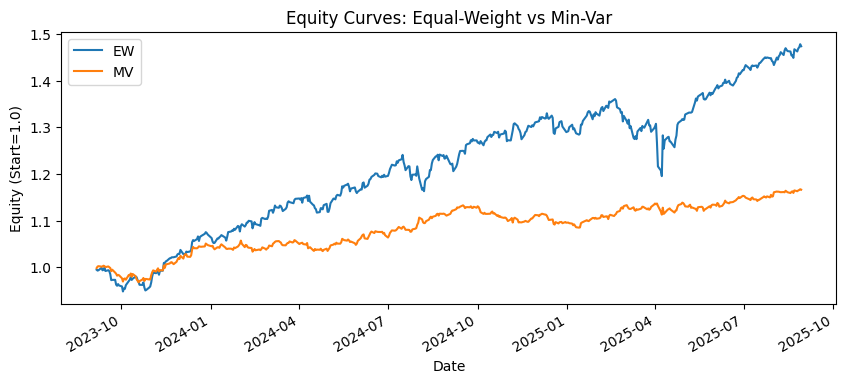

In [16]:
# Daily portfolio returns
ret_eq = (ret @ w_eq).rename('EW')
ret_mv = (ret @ w_mv).rename('MV')

# Equity curves (start=1.0)
equity = pd.DataFrame({
    'EW': (1+ret_eq).cumprod(),
    'MV': (1+ret_mv).cumprod()
})

equity.plot(title='Equity Curves: Equal-Weight vs Min-Var')
plt.ylabel('Equity (Start=1.0)')
plt.show()


In [17]:
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    close_df.to_excel(writer, sheet_name='Close')
    ret.to_excel(writer, sheet_name='Returns')
    stats.to_excel(writer, sheet_name='Asset_Stats')
    cov_annual.to_excel(writer, sheet_name='Cov_Annual')
    corr.to_excel(writer, sheet_name='Correlation')
    pd.DataFrame({'Equal-Weight': w_eq, 'Min-Var': w_mv}, index=tickers).to_excel(writer, sheet_name='Weights')
    perf_df.to_excel(writer, sheet_name='Portfolio_Perf')

    # Format Performance sheet
    ws = writer.sheets['Portfolio_Perf']
    ws.set_column('A:A', 18)
    ws.set_column('B:D', 18)

print(f"Results exported to: {output_file}")


Results exported to: C:\Users\parsa\OneDrive\Documents\portfolio_analysis.xlsx
